# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Ana Carolina Arellano Valdez

**Professor**: Pablo Camarillo Ramirez

# Introduction

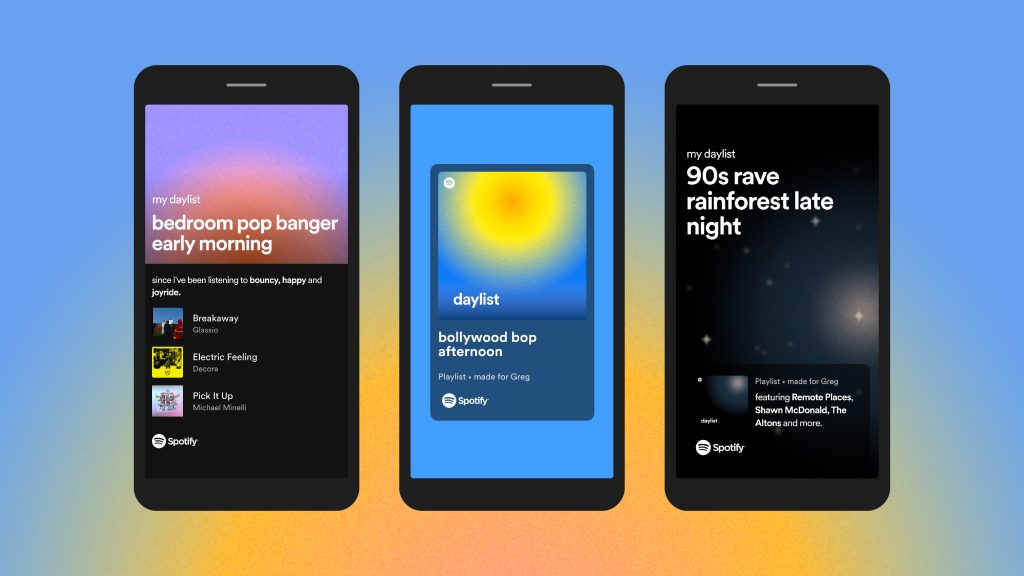 

In Spotify's recommendation system, keeping music suggestions accurate over time is a challenge. User tastes and trends change constantly, so I retrain the recommendation model regularly using historical data. This batch retraining process must handle large volumes of user interactions efficiently while ensuring that real-time recommendations remain uninterrupted.

The main challenge is finding the right balance between accuracy, performance, and scalability during model updates. In this project I demonstrate a batch processing solution using Apache Spark to process large-scale music streaming data for recommendation system training.

I structure user–music interaction signals (plays, skips, likes) to enable **smart, graph‑based recommendations**. A **graph** captures relationships between **Users**, **Tracks**, **Artists**, and **Genres**, letting me explore tastes and compute proximity (e.g., “users similar to me liked these tracks”, “tracks related by genre/artist/collective behavior”).

I process batched logs to aggregate listening preferences, then persist this knowledge into **Neo4j**, where I can query paths, neighbors, and weighted relationships for recommendations.

# Dataset

**Data model:** Graph.  
**Entities & relationships (simplified):**
- **User** node: `user_id`
- **Track** node: `track_id`, `title/album`, `duration_ms`
- **Artist** node: `name`
- **Genre** node: `name`
- **Relationships:**  
  - `(User)-[:PLAYED {count, last_ts}]->(Track)`  
  - `(User)-[:LIKED {count, last_ts}]->(Track)`  
  - `(Track)-[:BY]->(Artist)`  
  - `(Track)-[:IN_GENRE]->(Genre)`

**How the dataset is obtained:** We generate synthetic data with a Python script (`fake_data.py`) using the **Faker** library.
The script produces two CSVs: `tracks.csv` and `user_events.csv` in `data/carolinarellano/spotify_logs/`.


### Synthetic Data Generation

In [15]:
# Import the custom data generator
from carolinarellano.fake_data import FakeDataGenerator

# Initialize the generator
generator = FakeDataGenerator()

tracks_df, events_df = generator.generate_and_save_all(
    n_tracks=250,      
    n_users=50,
    n_events=1000
)

Generating fake data...
Saved tracks.csv with 250 rows to /opt/spark/work-dir/data/carolinarellano/spotify_logs/tracks.csv
Saved user_events.csv with 1000 rows to /opt/spark/work-dir/data/carolinarellano/spotify_logs/user_events.csv
Data generation complete!


## Data Verification

In [16]:
!pwd
!ls -la /opt/spark/work-dir/data/carolinarellano/spotify_logs

print("\n=== Sample of generated data files ===")
!head -5 /opt/spark/work-dir/data/carolinarellano/spotify_logs/tracks.csv
!head -5 /opt/spark/work-dir/data/carolinarellano/spotify_logs/user_events.csv

/opt/spark/work-dir
total 92
drwxr-xr-x 1 root root  4096 Oct 29 18:30 .
drwxr-xr-x 1 root root  4096 Oct 29 18:30 ..
-rw-r--r-- 1 root root 14014 Oct 29 22:43 tracks.csv
-rw-r--r-- 1 root root 75405 Oct 29 22:43 user_events.csv

=== Sample of generated data files ===
track_id,artist,album,duration_ms,genre
track_0000,Mallory Anderson,Night town,290091,electronic
track_0001,Erika Parks,Identify him spring course,221399,hiphop
track_0002,Larry Johnson,But mother,141051,country
track_0003,Melissa White,Dog bit so teach,177366,electronic
user_id,track_id,event_type,event_ts,session_id,device
user_0012,track_0108,skip,2025-09-01 00:37:03.139898,session_003117,mobile
user_0039,track_0144,like,2025-10-21 04:40:38.139898,session_002354,desktop
user_0002,track_0081,play,2025-10-28 20:33:28.139898,session_001076,mobile
user_0018,track_0031,play,2025-09-23 07:28:13.139898,session_000962,web player


## Dataset Overview

In [17]:
print("\n=== Tracks Data Overview ===")
print(tracks_df.head())
print("\n=== User Events Data Overview ===")
print(events_df.head())


=== Tracks Data Overview ===
     track_id            artist                       album  duration_ms  \
0  track_0000  Mallory Anderson                  Night town       290091   
1  track_0001       Erika Parks  Identify him spring course       221399   
2  track_0002     Larry Johnson                  But mother       141051   
3  track_0003     Melissa White            Dog bit so teach       177366   
4  track_0004    William Hayden               Senior chance        98617   

        genre  
0  electronic  
1      hiphop  
2     country  
3  electronic  
4         pop  

=== User Events Data Overview ===
     user_id    track_id event_type                   event_ts  \
0  user_0012  track_0108       skip 2025-09-01 00:37:03.139898   
1  user_0039  track_0144       like 2025-10-21 04:40:38.139898   
2  user_0002  track_0081       play 2025-10-28 20:33:28.139898   
3  user_0018  track_0031       play 2025-09-23 07:28:13.139898   
4  user_0032  track_0058       play 2025-09-28 01:39

# Spark Processing Pipeline

## Data Transformations and Actions

In [18]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on storage solutions with Neo4j") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.neo4j:neo4j-connector-apache-spark_2.13:5.3.10_for_spark_3") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
spark.conf.set("spark.sql.shuffle.partitions", "5")

### Load Data into Spark DataFrames

In [19]:
DATA_DIR = "/opt/spark/work-dir/data/carolinarellano/spotify_logs"

from carolinarellano.spark_utils import SparkUtils

schema_tracks = SparkUtils.generate_schema([("track_id", "string"),
                                  ("artist", "string"),
                                  ("album", "string"),
                                  ("duration_ms", "int"),
                                  ("genre", "string")])



schema_events = SparkUtils.generate_schema([("user_id", "string"),
                                  ("track_id", "string"),
                                  ("event_type", "string"),
                                  ("event_ts", "timestamp"),
                                  ("session_id", "string"),
                                  ("device", "string")])

df_tracks = spark.read.schema(schema_tracks).option("header", True).csv(f"{DATA_DIR}/tracks.csv")
df_events = spark.read.schema(schema_events).option("header", True).csv(f"{DATA_DIR}/user_events.csv")


In [24]:
from pyspark.sql.functions import col, to_timestamp

events_clean = (
    df_events
    .withColumn("event_ts", to_timestamp(col("event_ts").cast("string")))
    .filter(col("event_type").isin("play", "skip", "like", "pause", "seek"))
)

spotify_tracks_events = (
    events_clean.alias("e")
    .join(df_tracks.alias("t"), col("e.track_id") == col("t.track_id"), "left")
    .select("e.*", "t.artist", "t.album", "t.genre", "t.duration_ms")
)

# Tracks
tracks_nodes = spotify_tracks_events.select("track_id", "artist", "album", "genre", "duration_ms").distinct()
users_nodes = spotify_tracks_events.select("user_id", "device").distinct()
artists_nodes = tracks_nodes.select("artist").distinct().withColumnRenamed("artist", "name")
genres_nodes = tracks_nodes.select("genre").distinct().withColumnRenamed("genre", "name")

# Edges
# User -> Track relationships
user_track_edges = spotify_tracks_events.select(
    col("user_id").alias("source_user"),
    col("track_id").alias("target_track"),
    col("event_type"),
    col("event_ts"),
    col("session_id"),
    col("device")
).distinct()

# Track -> Artist relationships
track_artist_edges = tracks_nodes.select(
    col("track_id").alias("source_track"),
    col("artist").alias("target_artist")
).distinct()

# Track -> Genre relationships 
track_genre_edges = tracks_nodes.select(
    col("track_id").alias("source_track"),
    col("genre").alias("target_genre")
).distinct()


# Persistence Data

In [25]:
from pyspark.sql.functions import col

neo4j_url = "bolt://neo4j-iteso:7687"
neo4j_user = "neo4j"
neo4j_passwd = "neo4j@1234"

tracks_nodes.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("labels", ":Track") \
    .option("node.keys", "track_id") \
    .save()

print(f"{tracks_nodes.count()} track nodes written to Neo4j.")

users_nodes.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("labels", ":User") \
    .option("node.keys", "user_id") \
    .save()

print(f"{users_nodes.count()} user nodes written to Neo4j.")

artists_nodes.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("labels", ":Artist") \
    .option("node.keys", "name") \
    .save()

print(f"{artists_nodes.count()} artist nodes written to Neo4j.")

genres_nodes.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("labels", ":Genre") \
    .option("node.keys", "name") \
    .save()

print(f"{genres_nodes.count()} genre nodes written to Neo4j.")

248 track nodes written to Neo4j.
199 user nodes written to Neo4j.
248 artist nodes written to Neo4j.
9 genre nodes written to Neo4j.


In [27]:
# User -> Track relationships
user_track_edges.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("relationship", "INTERACTS_WITH") \
    .option("relationship.save.strategy", "keys") \
    .option("relationship.source.labels", ":User") \
    .option("relationship.source.save.mode", "match") \
    .option("relationship.source.keys", "source_user:user_id") \
    .option("relationship.target.labels", ":Track") \
    .option("relationship.target.save.mode", "match") \
    .option("relationship.target.keys", "target_track:track_id") \
    .save()

# Track -> Artist relationships
track_artist_edges.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("relationship", "PERFORMED_BY") \
    .option("relationship.save.strategy", "keys") \
    .option("relationship.source.labels", ":Track") \
    .option("relationship.source.save.mode", "match") \
    .option("relationship.source.keys", "source_track:track_id") \
    .option("relationship.target.labels", ":Artist") \
    .option("relationship.target.save.mode", "match") \
    .option("relationship.target.keys", "target_artist:name") \
    .save()

## Neo4j Database:

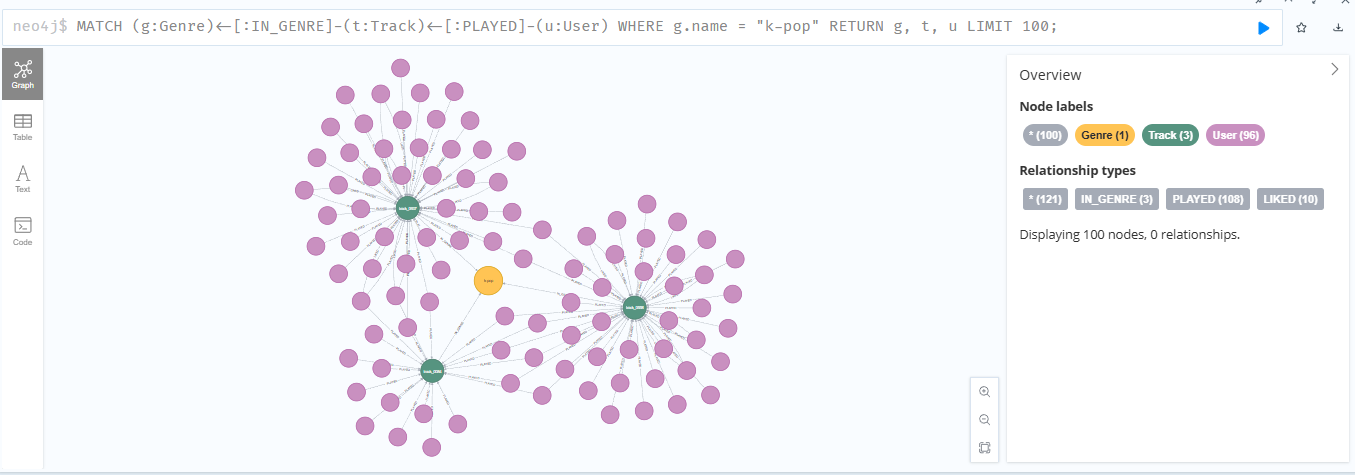

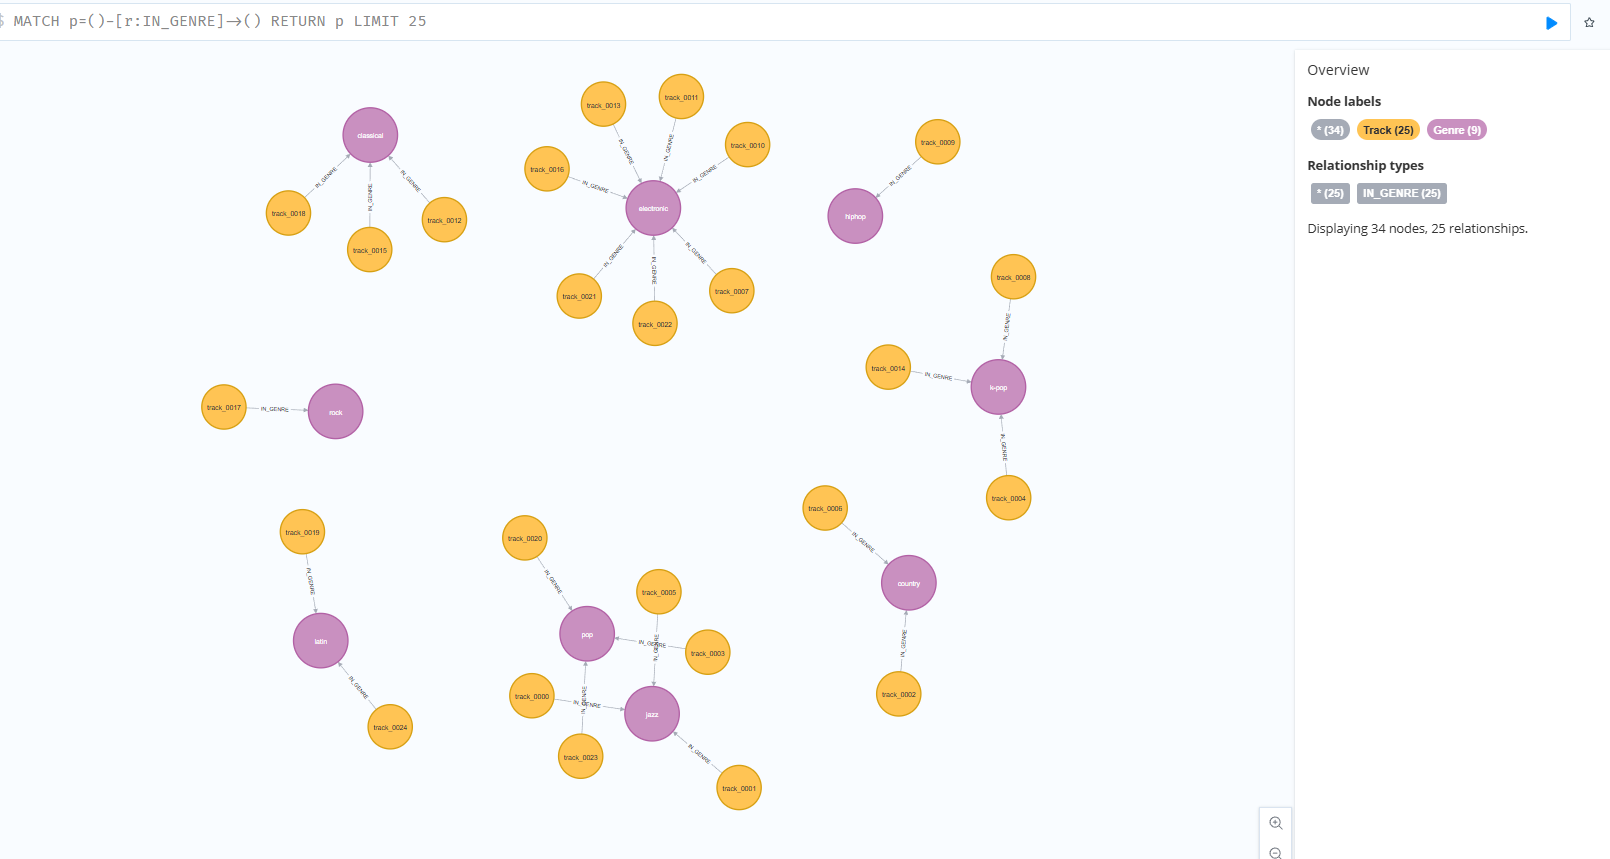

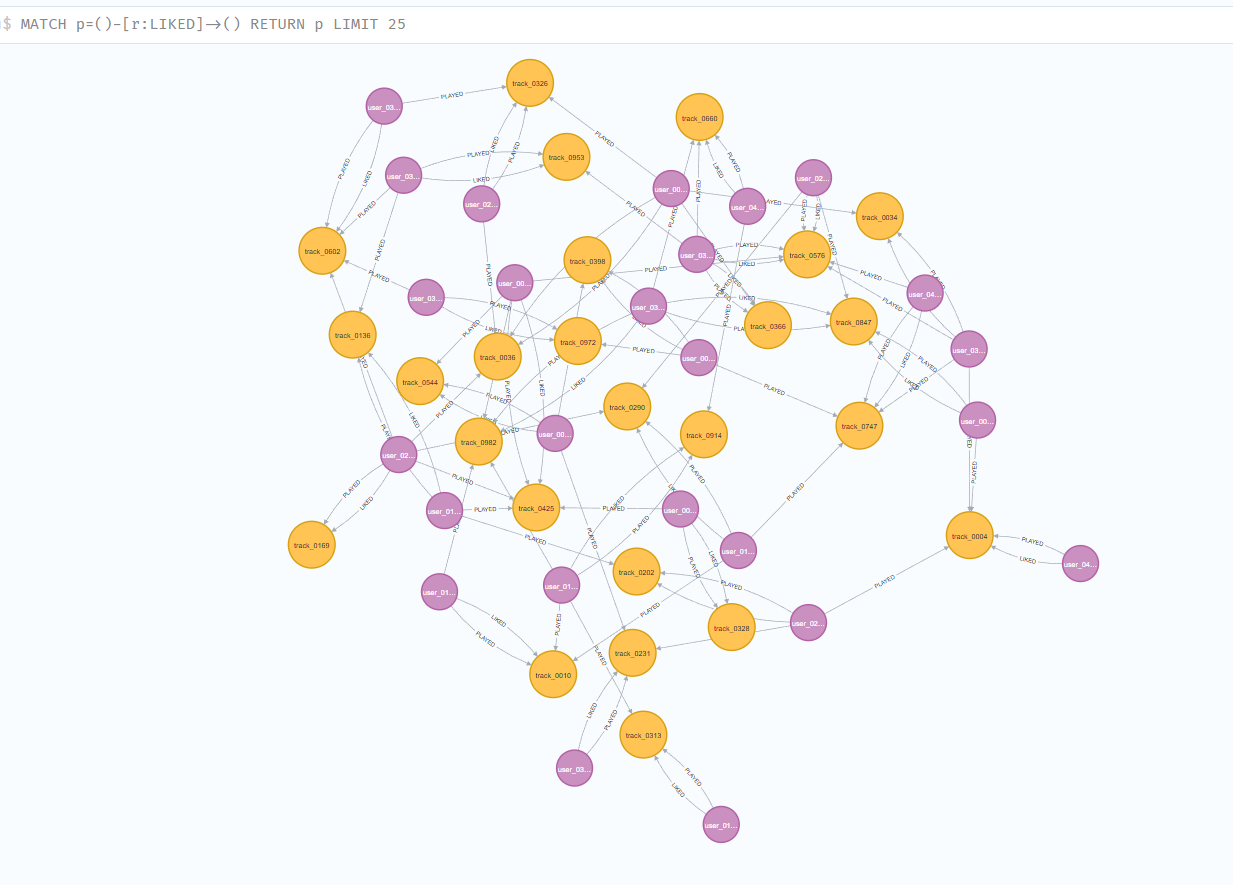


### Sample Queries in Neo4j Browser

```cypher
// 1) A user's top liked tracks
MATCH (u:User {user_id: "user_0001"})-[l:LIKED]->(t:Track)
RETURN t.track_id, l.count
ORDER BY l.count DESC
LIMIT 10;


// 2) Tracks by favorite genre of a user (based on plays)
MATCH (u:User {user_id: "user_0001"})-[p:PLAYED]->(t:Track)-[:IN_GENRE]->(g:Genre)
RETURN g.name, sum(p.count) AS total
ORDER BY total DESC;


// 3) “People like me also liked” (2‑hop)
MATCH (me:User {user_id: "user_0001"})-[:LIKED]->(t1:Track)<-[:LIKED]-(other:User)-[:LIKED]->(t2:Track)
WHERE t2 <> t1
RETURN t2.track_id, count(*) AS support
ORDER BY support DESC
LIMIT 10;

```

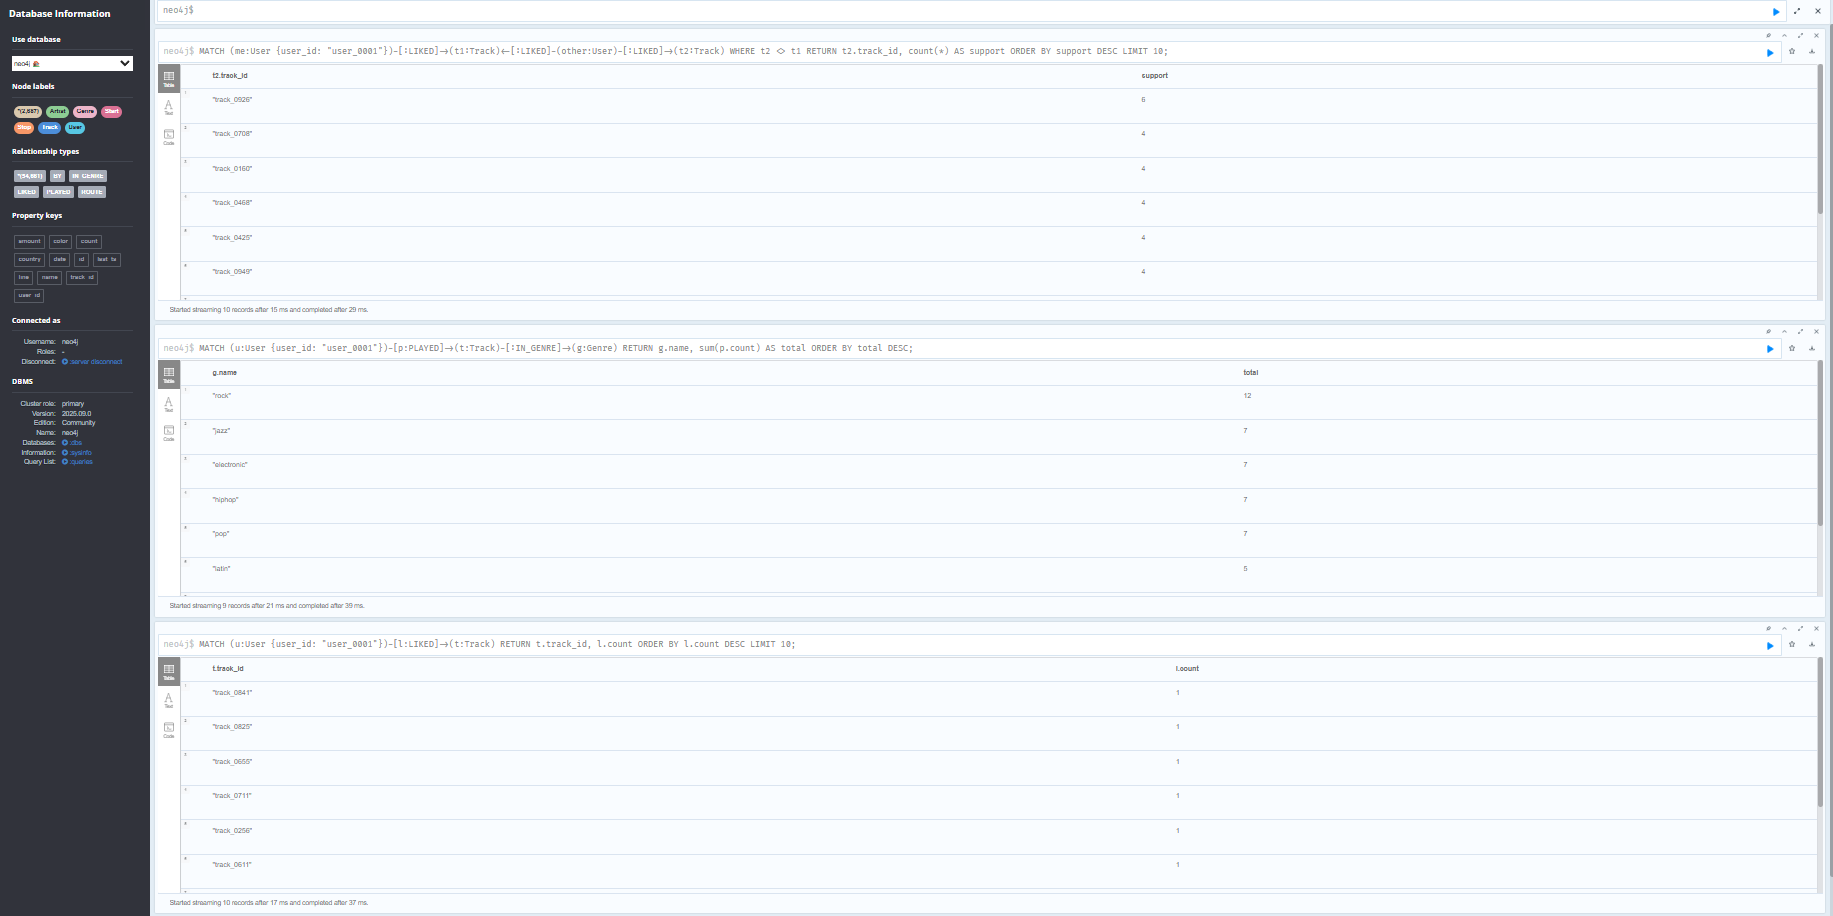

# DAG (Directed Acyclic Graph)

## Jobs Overview:
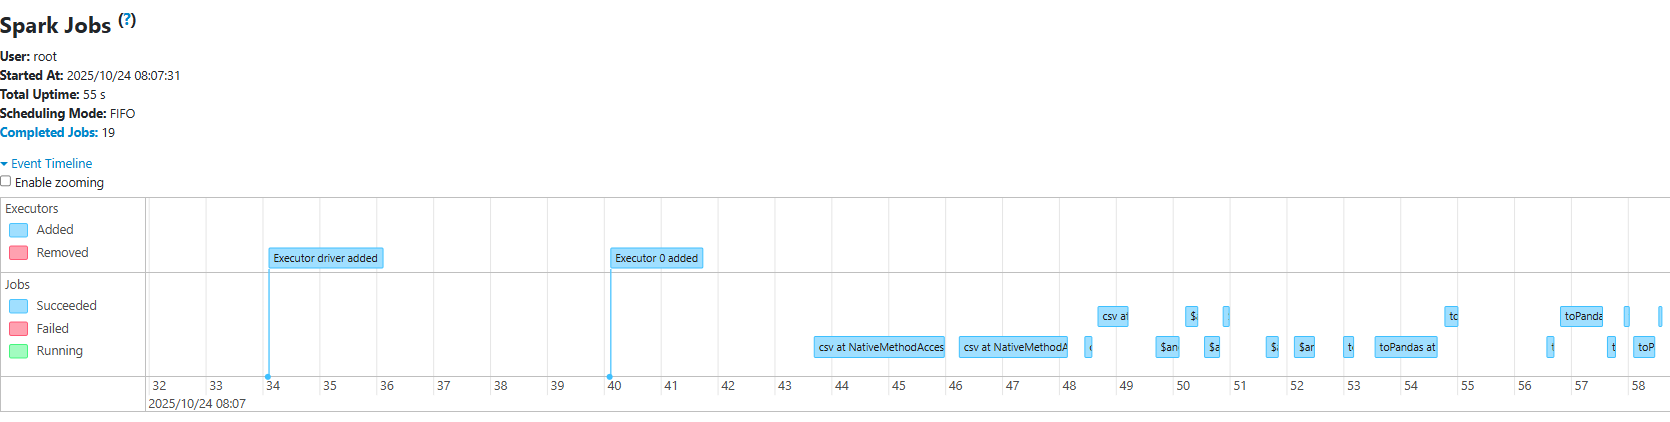



## Stage Visualization
### Job Stages
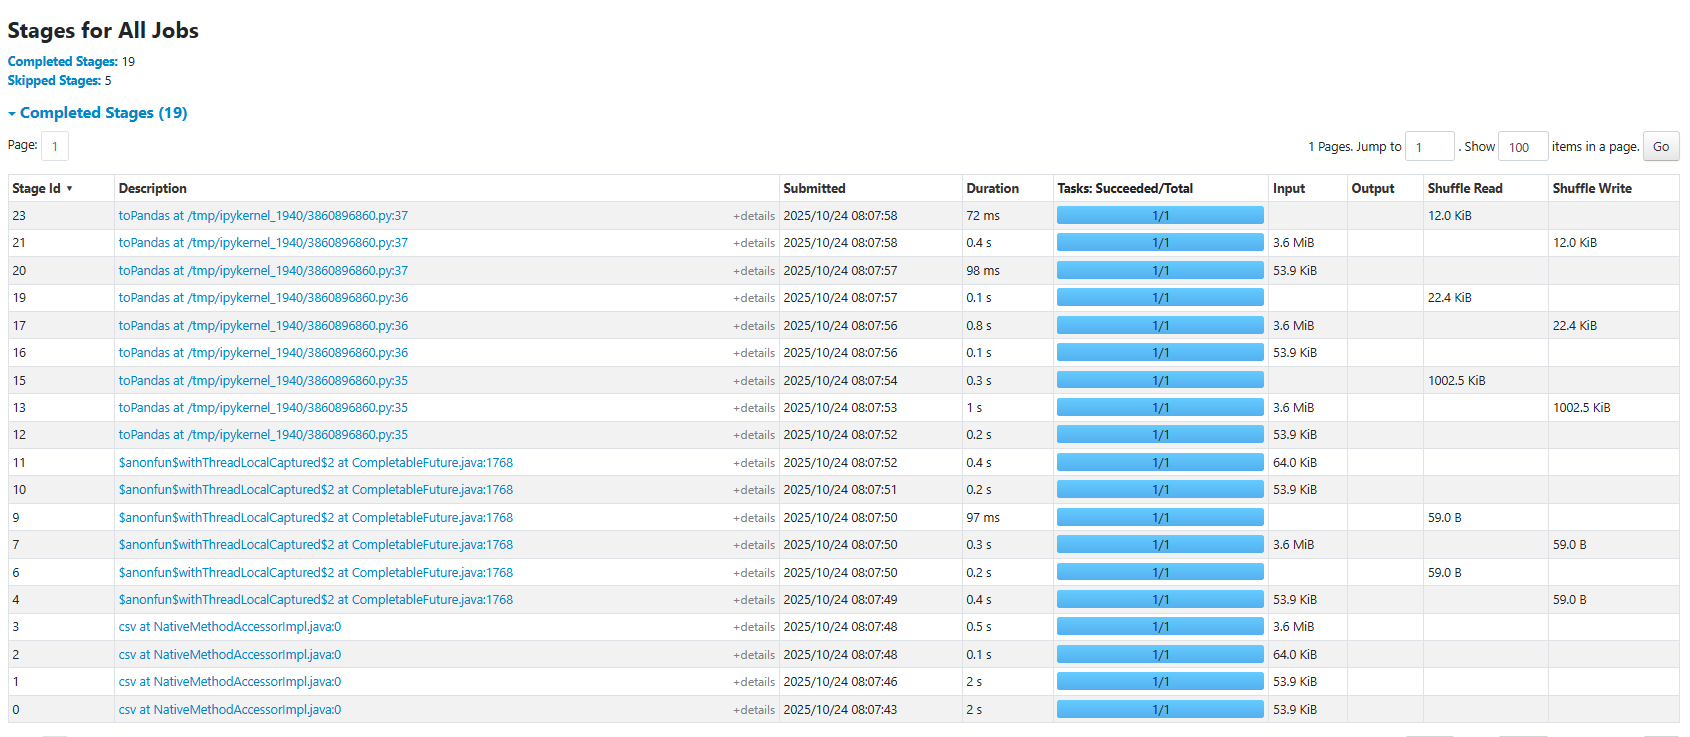

### Job Details
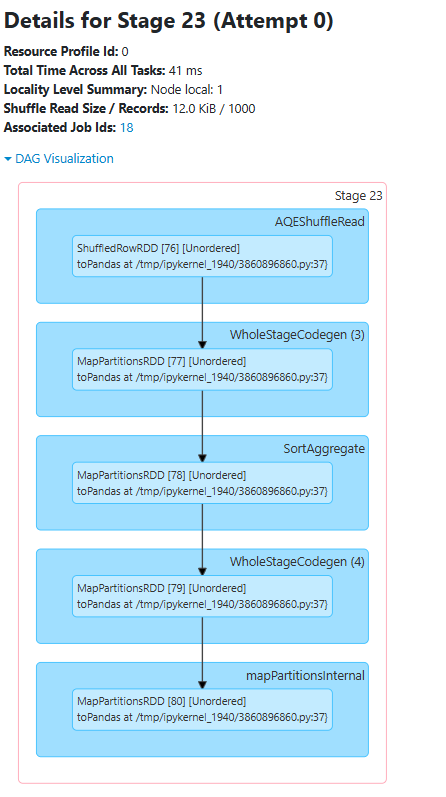

In [ ]:
sc.stop()